In [1]:

import sys
import shap 
import pickle
import sklearn 
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from types import SimpleNamespace



In [2]:



sys.path.append("../")

from dd_package.data.dyslexia_data import DyslexiaData
from dd_package.data.preprocess import preprocess_data

from dd_package.models.regression_estimators import RegressionEstimators

from dd_package.common.utils import save_a_dict, load_a_dict, print_the_evaluated_results





In [3]:

configs = {
    "models_path": Path("/home/soroosh/Programmes/DD/Models"),
    "results_path": Path("/home/soroosh/Programmes/DD/Results"),
    "figures_path": Path("/home/soroosh/Programmes/DD/Figures"),
    "params_path": Path("/home/soroosh/Programmes/DD//Params"),
    "n_repeats": 10,
    "n_splits": 5,
}

configs = SimpleNamespace(**configs)



In [4]:

data_name="dd_fix_demo"

estimator_name = "mlp_cls"
to_shuffle = True
to_exclude_at_risk = 0




In [5]:

specifier = data_name + "-" + estimator_name + \
"--shuffled:" + str(to_shuffle) + \
"--exclude at risk:" + str(to_exclude_at_risk)



In [6]:
configs.specifier = specifier
configs.data_name = data_name



In [7]:

configs.specifier



'dd_fix_demo-mlp_cls--shuffled:True--exclude at risk:0'

# demo-Fcls-mm:

- Chosen model: **MLP**



## Load Data

In [8]:


dd = DyslexiaData(path="../../datasets/", n_repeats=5)



In [17]:


if data_name == "dd_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos and phonological (which is initially part of demo)
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    df_data_to_use = demo_phono.loc[:, [
                                           'Group', 'SubjectID', 'Sex', 'Grade', 'Age', 'IQ', 'Reading_speed',
                                       ]]
    c_features = ['Sex', 'Grade', ]
    indicators = ['SubjectID', ]
    targets = ["Group", "Reading_speed", ]

elif data_name == "dd_fix_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos
    _ = dd.get_fix_datasets()  # fixes

    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    fix_demo = dd.concat_dfs(
        df1=fix,
        df2=demo_phono,
        features1=fix.columns,
        features2=[
            "Sex", "Grade", "Age", "IQ", "Reading_speed",
        ],
    )

    df_data_to_use = fix_demo
    c_features = ['Sex', 'Grade', ]
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", "Reading_speed", ]
    
elif data_name == "dd_fix":

    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_fix_datasets()  # fixes
    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]

    df_data_to_use = fix
    c_features = None
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", ]
    
    

Loading Demo data: 
  dyslexia (72, 9)
  norm (213, 9)
  risk (22, 9)
 
Loading Fixation report data:
  dyslexia (59770, 7)
  norm (139507, 7)
  risk (26073, 7)
 


In [18]:

df_data_to_use.head()



,Group,SubjectID,Sentence_ID,Word_Number,FIX_X,FIX_Y,FIX_DURATION,Sex,Grade,Age,IQ,Reading_speed
0,1,10,4,1,177.3,531.8,219.0,1,4,10,23,102.0
1,1,10,4,2,200.5,545.2,247.0,1,4,10,23,102.0
2,1,10,4,3,282.7,542.4,261.0,1,4,10,23,102.0
3,1,10,4,4,358.1,545.5,268.0,1,4,10,23,102.0
4,1,10,4,4,392.8,536.3,129.0,1,4,10,23,102.0


In [19]:


x_org, y_org = dd.get_onehot_features_targets(
    data=df_data_to_use,
    c_features=c_features,
    indicators=indicators,
    targets=targets,
)



In [20]:

x_org.head()



,Sex_2,Grade_4,FIX_DURATION,FIX_X,IQ,FIX_Y,Sex_1,Age,Grade_2,Grade_3,Grade_5,Grade_6,Grade_1
0,0,1,219.0,177.3,23,531.8,1,10,0,0,0,0,0
1,0,1,247.0,200.5,23,545.2,1,10,0,0,0,0,0
2,0,1,261.0,282.7,23,542.4,1,10,0,0,0,0,0
3,0,1,268.0,358.1,23,545.5,1,10,0,0,0,0,0
4,0,1,129.0,392.8,23,536.3,1,10,0,0,0,0,0


In [21]:
# for i in range(x_org.Sex_1.values.shape[0]):
#     print(x_org.Sex_1.values[i], x_org.Sex_2.values[i])

In [22]:

y_org.head()



,Group,Reading_speed
0,1,102.0
1,1,102.0
2,1,102.0
3,1,102.0
4,1,102.0


In [23]:


estimator_name = "MLP_cls"

if estimator_name.split("_")[-1] == "reg":
    learning_method = "regression"
    y = y_org.Reading_speed.values

elif estimator_name.split("_")[-1] == "cls":
    learning_method = "classification"
    y = y_org.Group.values

elif estimator_name.split("_")[-1] == "clu":
    from dd_package.models.clustering_estimators import ClusteringEstimators
    y = y_org.Group.values
else:
    assert False, "Undefined algorithm and thus undefined target values"
    
print("learning_method:", learning_method)



learning_method: classification


In [24]:

x = preprocess_data(x=x_org, pp="mm")  # only x is standardized



pre-processing: mm
Preprocessed data shape: (225350, 13)


In [25]:

data = dd.get_stratified_train_test_splits(
        x=x, y=y,
        labels=y_org.Group.values,
        to_shuffle=to_shuffle,
        n_splits=10
    )



In [26]:

data



defaultdict(collections.defaultdict,
            {'1': defaultdict(list,
                         {'x_train': array([[0.   , 1.   , 0.022, ..., 0.   , 0.   , 0.   ],
                                 [0.   , 1.   , 0.025, ..., 0.   , 0.   , 0.   ],
                                 [0.   , 1.   , 0.027, ..., 0.   , 0.   , 0.   ],
                                 ...,
                                 [1.   , 0.   , 0.02 , ..., 0.   , 0.   , 0.   ],
                                 [1.   , 0.   , 0.015, ..., 0.   , 0.   , 0.   ],
                                 [1.   , 0.   , 0.019, ..., 0.   , 0.   , 0.   ]]),
                          'x_test': array([[0.   , 1.   , 0.026, ..., 0.   , 0.   , 0.   ],
                                 [0.   , 1.   , 0.02 , ..., 0.   , 0.   , 0.   ],
                                 [0.   , 1.   , 0.018, ..., 0.   , 0.   , 0.   ],
                                 ...,
                                 [1.   , 0.   , 0.037, ..., 0.   , 0.   , 0.   ],
        

## Load the tuned parameters

In [27]:

tuned_params = load_a_dict(
    name=configs.specifier,
    save_path=configs.params_path
        )
tuned_params



OrderedDict([('activation', 'tanh'),
             ('hidden_layer_sizes', 158),
             ('max_iter', 49150),
             ('solver', 'lbfgs')])

In [28]:


specifier



'dd_fix_demo-mlp_cls--shuffled:True--exclude at risk:0'

In [ ]:
# save_a_dict(a_dict=tuned_params,
#             name='dd_fix_demo-mlp_reg--shuffled:True--exclude at risk:0',
#             save_path=configs.params_path,
#            )

In [29]:

mdl = sklearn.neural_network.MLPClassifier(
    activation=tuned_params["activation"], 
    hidden_layer_sizes=tuned_params["hidden_layer_sizes"],
    max_iter=tuned_params["max_iter"],
    solver=tuned_params["solver"],
    verbose=1
)

mdl




MLPClassifier(activation='tanh', hidden_layer_sizes=158, max_iter=49150,
              solver='lbfgs', verbose=1)

In [49]:
x_train = data["6"]["x_train"]
tmp_x_test = data["6"]["x_test"]
y_train = data["6"]["y_train"]
tmp_y_test = data["6"]["y_test"]



In [31]:

class_names = ['Norm', 'At-risk', 'Dyslexic']




## Load new test data

In [32]:


data_sets_xls = pd.ExcelFile("../../datasets/Fix_Demo_test_data.xlsx")
print(data_sets_xls.sheet_names)




['fixations_test', 'demography_test']


In [33]:

print("Loading Demo data: ")
tmp_demo = pd.read_excel(data_sets_xls, 'demography_test',)
tmp_demo = dd._remove_missing_data(df=tmp_demo)


tmp_demo.replace(
    to_replace={"Sex": {"fem": 1, "f": 1, "masc": 2, "m": 2}},
    inplace=True,
)


tmp_demo = tmp_demo.astype({
    "SubjectID": str,
    "Sex": int,
    "Grade": int,
    "Age": int,
    "IQ": int,
})



demo_new = tmp_demo.sort_values(by=["SubjectID"]).dropna()

print(" ", demo_new.shape)
print(" ")




demo_new.head()



Loading Demo data: 
  (20, 5)
 


,SubjectID,Sex,Grade,Age,IQ
1,nnr26,2,3,9,28
2,nnr27,1,3,10,26
3,nnr33,1,1,7,24
4,nnr36,2,1,7,21
5,nnr41,2,2,9,30


In [34]:



print("Loading Fix data: ")
tmp_fix = pd.read_excel(data_sets_xls, 'fixations_test',)
tmp_fix = dd._remove_missing_data(df=tmp_fix)


tmp_fix.replace(
    to_replace={"Sex": {"fem": 1, "f": 1, "masc": 2, "m": 2}},
    inplace=True,
)



tmp_fix.astype({
    "SubjectID": str,
    "Sentence_ID": int,
    "Word_Number": int,
    "FIX_X": float,
    "FIX_Y": float,
    "FIX_DURATION": float,
})



fix_new = tmp_fix.sort_values(by=["SubjectID"]).dropna()

print(" ", fix_new.shape)
print(" ")


fix_new.head()




Loading Fix data: 
  (15916, 6)
 


,SubjectID,Sentence_ID,Word_Number,FIX_X,FIX_Y,FIX_DURATION
1326,nnr26,15,4,392.1,543.5,351
1149,nnr26,32,3,373.4,554.5,362
1148,nnr26,32,3,397.3,554.1,214
1147,nnr26,32,2,258.8,556.2,217
1146,nnr26,32,2,243.4,550.2,168


In [35]:


fix_demo_new = dd.concat_dfs(
            df1=fix_new,
            df2=demo_new,
            features1=fix_new.columns,
            features2=[
                "Sex", "Grade", "Age", "IQ",
            ],
        )



In [36]:


set(fix_demo_new.Grade), set(fix_demo.Grade)





({1, 2, 3, 4}, {1, 2, 3, 4, 5, 6})

In [38]:


fix_demo_new.shape



(15916, 10)

In [39]:

fix_demo_new.loc[-1] = ['ext-G5', 1, 1, 123, 123, 123, 1, 5, 123, 123]
fix_demo_new.index = fix_demo_new.index + 1  # shifting index

fix_demo_new.loc[-2] = ['ext-G6', 1, 1, 123, 123, 123, 1, 6, 123, 123]
fix_demo_new.index = fix_demo_new.index + 1  # shifting index


fix_demo_new.shape



(15918, 10)

In [41]:

fix_demo_new



,SubjectID,Sentence_ID,Word_Number,FIX_X,FIX_Y,FIX_DURATION,Sex,Grade,Age,IQ
2,nnr26,15,4,392.1,543.5,351,2,3,9,28
3,nnr26,32,3,373.4,554.5,362,2,3,9,28
4,nnr26,32,3,397.3,554.1,214,2,3,9,28
5,nnr26,32,2,258.8,556.2,217,2,3,9,28
6,nnr26,32,2,243.4,550.2,168,2,3,9,28
...,...,...,...,...,...,...,...,...,...,...
439,nnr85,16,6,916.8,524.0,373,1,3,9,35
440,nnr85,8,3,432.6,474.4,144,1,3,9,35
441,nnr85,17,2,281.1,544.4,43,1,3,9,35
1,ext-G5,1,1,123.0,123.0,123,1,5,123,123


In [47]:


indicators = ["SubjectID", "Sentence_ID", "Word_Number", ]

fix_demo_new_dum = pd.get_dummies(data=fix_demo_new, columns=c_features)

features = list(
    set(fix_demo_new_dum.columns).difference(
        set(indicators).union(set())
    )
)


x_test = fix_demo_new_dum.loc[:, features]
x_test



,FIX_DURATION,Grade_4,IQ,FIX_Y,Sex_1,Grade_2,Grade_5,Grade_6,Grade_1,Sex_2,FIX_X,Age,Grade_3
2,351,0,28,543.5,0,0,0,0,0,1,392.1,9,1
3,362,0,28,554.5,0,0,0,0,0,1,373.4,9,1
4,214,0,28,554.1,0,0,0,0,0,1,397.3,9,1
5,217,0,28,556.2,0,0,0,0,0,1,258.8,9,1
6,168,0,28,550.2,0,0,0,0,0,1,243.4,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,373,0,35,524.0,1,0,0,0,0,0,916.8,9,1
440,144,0,35,474.4,1,0,0,0,0,0,432.6,9,1
441,43,0,35,544.4,1,0,0,0,0,0,281.1,9,1
1,123,0,123,123.0,1,0,1,0,0,0,123.0,123,0


In [52]:

tmp_x_test.shape



(22535, 13)

In [53]:

x_org.shape





(225350, 13)

## Previously obtained results

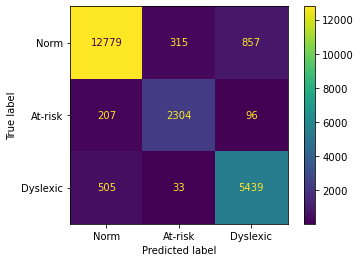

Kappa: 0.8347400437872468 AUC ROC: 0.9825072610728137


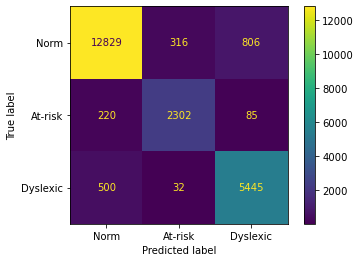

Kappa: 0.8388978522946917 AUC ROC: 0.9829182453627607


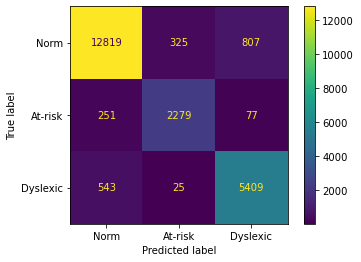

Kappa: 0.832869081391151 AUC ROC: 0.9823166765651608


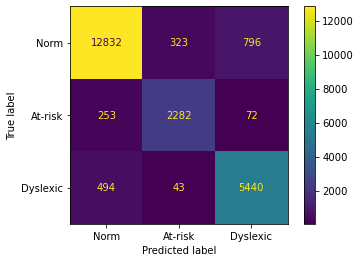

Kappa: 0.8369422822490217 AUC ROC: 0.9828148640073884


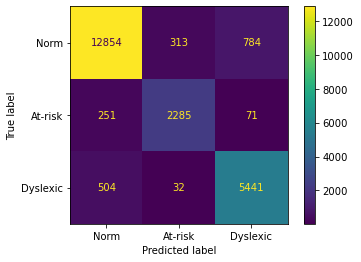

Kappa: 0.8389059114142479 AUC ROC: 0.9829848306845811


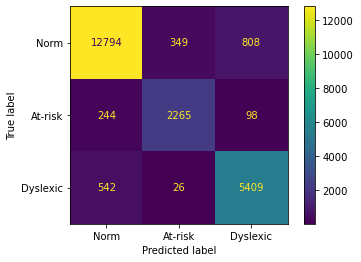

Kappa: 0.829841840423335 AUC ROC: 0.9823257928381303


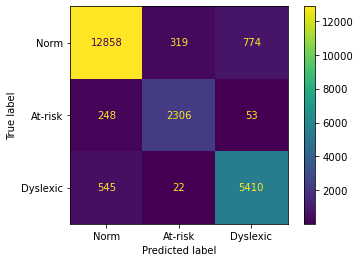

Kappa: 0.8382473045222396 AUC ROC: 0.9827749230027788


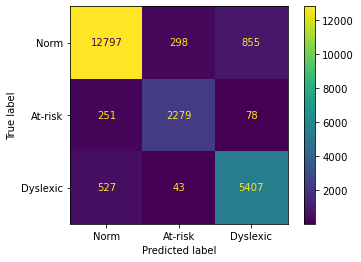

Kappa: 0.8310664313696852 AUC ROC: 0.9821932698756151


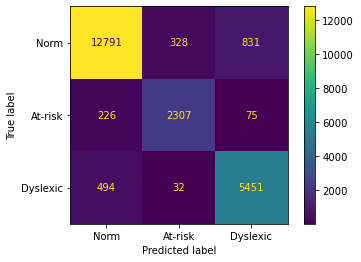

Kappa: 0.8368983636632326 AUC ROC: 0.9830666923198533


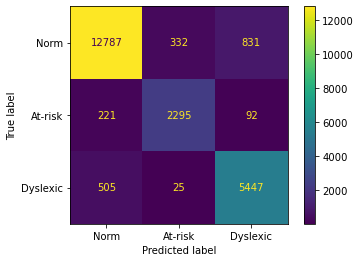

Kappa: 0.8352159256796329 AUC ROC: 0.9824885993933525


In [54]:

results = load_a_dict(
    name=configs.specifier,
    save_path=configs.results_path,
        )




for i in range(1, 11):
    i = str(i)
    y_test_ = results[i]["y_test"]
    y_pred_ = results[i]["y_pred"]
    y_prob_ = results[i]["y_pred_prob"]
    
    cm = sklearn.metrics.confusion_matrix(
    y_true=y_test_, 
    y_pred=y_pred_
    )
    
    disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names
                             )
    disp.plot()
    plt.show()
    
    
    print(
        "Kappa:", sklearn.metrics.cohen_kappa_score(y1=y_test_, y2=y_pred_),
        
        "AUC ROC:", sklearn.metrics.roc_auc_score(y_test_, y_prob_,
                                                  multi_class="ovr",
                                                  average="weighted")
    )





In [56]:


print_the_evaluated_results(
    results=results, 
    learning_method=learning_method
)



  ari    nmi  	 preci 	 recall  	 f1_score  	 roc_auc  	 meape  	 jsd  	 acc
 Ave   std  Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std 
0.730 0.004 0.631 0.005 0.913 0.002 0.911 0.002 0.912 0.002 0.983 0.000 1.960 0.018 0.103 0.001 0.911 0.002


In [ ]:


mdl.fit(x_train, y_train)




RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2689     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.81083D-01    |proj g|=  1.39356D-01


 This problem is unconstrained.



At iterate    1    f=  9.04099D-01    |proj g|=  4.81611D-02

At iterate    2    f=  8.81755D-01    |proj g|=  2.30960D-02

At iterate    3    f=  8.54403D-01    |proj g|=  4.48799D-02

At iterate    4    f=  8.36626D-01    |proj g|=  3.26220D-02

At iterate    5    f=  8.13578D-01    |proj g|=  7.16631D-03

At iterate    6    f=  8.07033D-01    |proj g|=  6.22330D-03

At iterate    7    f=  8.02285D-01    |proj g|=  6.29227D-03

At iterate    8    f=  7.96723D-01    |proj g|=  5.92686D-03

At iterate    9    f=  7.93593D-01    |proj g|=  8.05904D-03

At iterate   10    f=  7.92049D-01    |proj g|=  4.06626D-03

At iterate   11    f=  7.90925D-01    |proj g|=  2.00343D-03

At iterate   12    f=  7.89886D-01    |proj g|=  1.15374D-02

At iterate   13    f=  7.88940D-01    |proj g|=  4.03961D-03

At iterate   14    f=  7.88353D-01    |proj g|=  2.64696D-03

At iterate   15    f=  7.87012D-01    |proj g|=  3.34096D-03

At iterate   16    f=  7.85087D-01    |proj g|=  3.83814D-03

At iter


At iterate  134    f=  6.49212D-01    |proj g|=  2.29781D-02

At iterate  135    f=  6.47458D-01    |proj g|=  1.26771D-02

At iterate  136    f=  6.46167D-01    |proj g|=  9.86231D-03

At iterate  137    f=  6.45103D-01    |proj g|=  1.49253D-02

At iterate  138    f=  6.44185D-01    |proj g|=  1.07790D-02

At iterate  139    f=  6.42656D-01    |proj g|=  1.72185D-02

At iterate  140    f=  6.39981D-01    |proj g|=  1.53526D-02

At iterate  141    f=  6.38217D-01    |proj g|=  1.52685D-02

At iterate  142    f=  6.36959D-01    |proj g|=  1.24849D-02

At iterate  143    f=  6.35742D-01    |proj g|=  2.81870D-02

At iterate  144    f=  6.33855D-01    |proj g|=  1.09016D-02

At iterate  145    f=  6.33077D-01    |proj g|=  8.11766D-03

At iterate  146    f=  6.32411D-01    |proj g|=  9.76794D-03

At iterate  147    f=  6.30985D-01    |proj g|=  1.26821D-02

At iterate  148    f=  6.29672D-01    |proj g|=  1.92974D-02

At iterate  149    f=  6.28313D-01    |proj g|=  9.18224D-03

At iter


At iterate  267    f=  5.37626D-01    |proj g|=  1.34487D-02

At iterate  268    f=  5.37208D-01    |proj g|=  7.96863D-03

At iterate  269    f=  5.37095D-01    |proj g|=  8.09263D-03

At iterate  270    f=  5.36745D-01    |proj g|=  6.83568D-03

At iterate  271    f=  5.36138D-01    |proj g|=  9.10507D-03

At iterate  272    f=  5.35672D-01    |proj g|=  8.42668D-03

At iterate  273    f=  5.35287D-01    |proj g|=  1.00303D-02

At iterate  274    f=  5.34777D-01    |proj g|=  9.47504D-03

At iterate  275    f=  5.34136D-01    |proj g|=  6.51729D-03

At iterate  276    f=  5.32993D-01    |proj g|=  6.88031D-03

At iterate  277    f=  5.31734D-01    |proj g|=  1.27836D-02

At iterate  278    f=  5.30615D-01    |proj g|=  1.06795D-02

At iterate  279    f=  5.30234D-01    |proj g|=  1.69422D-02

At iterate  280    f=  5.29773D-01    |proj g|=  9.64233D-03

At iterate  281    f=  5.29421D-01    |proj g|=  8.10229D-03

At iterate  282    f=  5.29019D-01    |proj g|=  6.38391D-03

At iter


At iterate  400    f=  4.57130D-01    |proj g|=  7.36845D-03

At iterate  401    f=  4.56532D-01    |proj g|=  6.59281D-03

At iterate  402    f=  4.56239D-01    |proj g|=  2.05029D-02

At iterate  403    f=  4.55478D-01    |proj g|=  9.18299D-03

At iterate  404    f=  4.55180D-01    |proj g|=  8.64359D-03

At iterate  405    f=  4.54389D-01    |proj g|=  6.28177D-03

At iterate  406    f=  4.53204D-01    |proj g|=  6.74511D-03

At iterate  407    f=  4.52383D-01    |proj g|=  9.06362D-03

At iterate  408    f=  4.51525D-01    |proj g|=  7.64342D-03

At iterate  409    f=  4.51019D-01    |proj g|=  5.36224D-03

At iterate  410    f=  4.50402D-01    |proj g|=  6.02772D-03

At iterate  411    f=  4.49496D-01    |proj g|=  1.36044D-02

At iterate  412    f=  4.48140D-01    |proj g|=  9.28116D-03

At iterate  413    f=  4.46752D-01    |proj g|=  8.03602D-03

At iterate  414    f=  4.46099D-01    |proj g|=  1.96048D-02

At iterate  415    f=  4.45169D-01    |proj g|=  7.18864D-03

At iter


At iterate  533    f=  3.94007D-01    |proj g|=  9.67831D-03

At iterate  534    f=  3.93634D-01    |proj g|=  8.55380D-03

At iterate  535    f=  3.93023D-01    |proj g|=  8.20661D-03

At iterate  536    f=  3.92482D-01    |proj g|=  8.76882D-03

At iterate  537    f=  3.91976D-01    |proj g|=  5.99325D-03

At iterate  538    f=  3.91635D-01    |proj g|=  8.52283D-03

At iterate  539    f=  3.91349D-01    |proj g|=  5.94702D-03

At iterate  540    f=  3.91046D-01    |proj g|=  4.71531D-03

At iterate  541    f=  3.90626D-01    |proj g|=  1.25682D-02

At iterate  542    f=  3.90102D-01    |proj g|=  7.47109D-03

At iterate  543    f=  3.89702D-01    |proj g|=  6.97997D-03

At iterate  544    f=  3.89144D-01    |proj g|=  7.39901D-03

At iterate  545    f=  3.88609D-01    |proj g|=  5.52981D-03

At iterate  546    f=  3.87943D-01    |proj g|=  1.04740D-02

At iterate  547    f=  3.87574D-01    |proj g|=  1.18667D-02

At iterate  548    f=  3.87012D-01    |proj g|=  6.33380D-03

At iter


At iterate  666    f=  3.50110D-01    |proj g|=  3.97884D-03

At iterate  667    f=  3.49847D-01    |proj g|=  3.27226D-03

At iterate  668    f=  3.49638D-01    |proj g|=  1.07639D-02

At iterate  669    f=  3.49448D-01    |proj g|=  1.26581D-02

At iterate  670    f=  3.49330D-01    |proj g|=  7.03502D-03

At iterate  671    f=  3.49230D-01    |proj g|=  4.22314D-03

At iterate  672    f=  3.49067D-01    |proj g|=  6.86647D-03

At iterate  673    f=  3.48765D-01    |proj g|=  9.54843D-03

At iterate  674    f=  3.48379D-01    |proj g|=  7.53166D-03

At iterate  675    f=  3.48314D-01    |proj g|=  1.34504D-02

At iterate  676    f=  3.47772D-01    |proj g|=  5.68466D-03

At iterate  677    f=  3.47612D-01    |proj g|=  4.86926D-03

At iterate  678    f=  3.47388D-01    |proj g|=  6.41545D-03

At iterate  679    f=  3.47064D-01    |proj g|=  1.00632D-02

At iterate  680    f=  3.46771D-01    |proj g|=  1.27466D-02

At iterate  681    f=  3.46514D-01    |proj g|=  5.15264D-03

At iter


At iterate  799    f=  3.13967D-01    |proj g|=  8.86583D-03

At iterate  800    f=  3.13735D-01    |proj g|=  3.37058D-02

At iterate  801    f=  3.13035D-01    |proj g|=  9.82702D-03

At iterate  802    f=  3.12753D-01    |proj g|=  6.37743D-03

At iterate  803    f=  3.12530D-01    |proj g|=  1.45212D-02

At iterate  804    f=  3.12344D-01    |proj g|=  1.12505D-02

At iterate  805    f=  3.12136D-01    |proj g|=  8.77589D-03

At iterate  806    f=  3.11673D-01    |proj g|=  6.43400D-03

At iterate  807    f=  3.11436D-01    |proj g|=  5.99679D-03

At iterate  808    f=  3.11010D-01    |proj g|=  8.52687D-03

At iterate  809    f=  3.10730D-01    |proj g|=  1.30193D-02

At iterate  810    f=  3.10396D-01    |proj g|=  6.09663D-03

At iterate  811    f=  3.10047D-01    |proj g|=  5.44852D-03

At iterate  812    f=  3.09719D-01    |proj g|=  6.32139D-03

At iterate  813    f=  3.09261D-01    |proj g|=  1.16368D-02

At iterate  814    f=  3.08927D-01    |proj g|=  1.48031D-02

At iter


At iterate  932    f=  2.73755D-01    |proj g|=  8.91987D-03

At iterate  933    f=  2.73398D-01    |proj g|=  6.09199D-03

At iterate  934    f=  2.72985D-01    |proj g|=  1.17398D-02

At iterate  935    f=  2.72698D-01    |proj g|=  1.04660D-02

At iterate  936    f=  2.72466D-01    |proj g|=  7.72213D-03

At iterate  937    f=  2.72289D-01    |proj g|=  6.55995D-03

At iterate  938    f=  2.71928D-01    |proj g|=  7.51779D-03

At iterate  939    f=  2.71599D-01    |proj g|=  4.63987D-03

At iterate  940    f=  2.71347D-01    |proj g|=  3.94286D-03

At iterate  941    f=  2.71286D-01    |proj g|=  1.76552D-02

At iterate  942    f=  2.70764D-01    |proj g|=  6.73231D-03

At iterate  943    f=  2.70487D-01    |proj g|=  3.73351D-03

At iterate  944    f=  2.70219D-01    |proj g|=  6.21205D-03

At iterate  945    f=  2.69775D-01    |proj g|=  9.97527D-03

At iterate  946    f=  2.69457D-01    |proj g|=  1.28458D-02

At iterate  947    f=  2.68972D-01    |proj g|=  6.51178D-03

At iter


At iterate 1065    f=  2.47742D-01    |proj g|=  5.28261D-03

At iterate 1066    f=  2.47656D-01    |proj g|=  1.12187D-02

At iterate 1067    f=  2.47479D-01    |proj g|=  6.46331D-03

At iterate 1068    f=  2.47260D-01    |proj g|=  7.24064D-03

At iterate 1069    f=  2.47072D-01    |proj g|=  1.10749D-02

At iterate 1070    f=  2.46894D-01    |proj g|=  8.47124D-03

At iterate 1071    f=  2.46710D-01    |proj g|=  4.69338D-03

At iterate 1072    f=  2.46560D-01    |proj g|=  8.32373D-03

At iterate 1073    f=  2.46431D-01    |proj g|=  6.54172D-03

At iterate 1074    f=  2.46335D-01    |proj g|=  5.37382D-03

At iterate 1075    f=  2.46188D-01    |proj g|=  3.97288D-03

At iterate 1076    f=  2.46055D-01    |proj g|=  4.14500D-03

At iterate 1077    f=  2.45765D-01    |proj g|=  9.58126D-03

At iterate 1078    f=  2.45662D-01    |proj g|=  1.35360D-02

At iterate 1079    f=  2.45393D-01    |proj g|=  4.35637D-03

At iterate 1080    f=  2.45270D-01    |proj g|=  3.40482D-03

At iter


At iterate 1198    f=  2.32569D-01    |proj g|=  4.04437D-03

At iterate 1199    f=  2.32530D-01    |proj g|=  6.57424D-03

At iterate 1200    f=  2.32490D-01    |proj g|=  3.05135D-03

At iterate 1201    f=  2.32461D-01    |proj g|=  2.00487D-03

At iterate 1202    f=  2.32405D-01    |proj g|=  3.25091D-03

At iterate 1203    f=  2.32302D-01    |proj g|=  4.44405D-03

At iterate 1204    f=  2.32191D-01    |proj g|=  7.15298D-03

At iterate 1205    f=  2.32114D-01    |proj g|=  5.18223D-03

At iterate 1206    f=  2.32035D-01    |proj g|=  3.09505D-03

At iterate 1207    f=  2.31976D-01    |proj g|=  3.66009D-03

At iterate 1208    f=  2.31916D-01    |proj g|=  3.97823D-03

At iterate 1209    f=  2.31877D-01    |proj g|=  6.58728D-03

At iterate 1210    f=  2.31796D-01    |proj g|=  2.71396D-03

At iterate 1211    f=  2.31750D-01    |proj g|=  3.10472D-03

At iterate 1212    f=  2.31738D-01    |proj g|=  1.33096D-02

At iterate 1213    f=  2.31679D-01    |proj g|=  5.10253D-03

At iter


At iterate 1331    f=  2.25960D-01    |proj g|=  3.38676D-03

At iterate 1332    f=  2.25929D-01    |proj g|=  3.11373D-03

At iterate 1333    f=  2.25878D-01    |proj g|=  3.04795D-03

At iterate 1334    f=  2.25809D-01    |proj g|=  4.52579D-03

At iterate 1335    f=  2.25772D-01    |proj g|=  1.08170D-02

At iterate 1336    f=  2.25681D-01    |proj g|=  3.72024D-03

At iterate 1337    f=  2.25655D-01    |proj g|=  2.10578D-03

At iterate 1338    f=  2.25618D-01    |proj g|=  2.81119D-03

At iterate 1339    f=  2.25581D-01    |proj g|=  5.05576D-03

At iterate 1340    f=  2.25538D-01    |proj g|=  2.69270D-03

At iterate 1341    f=  2.25491D-01    |proj g|=  2.05972D-03

At iterate 1342    f=  2.25464D-01    |proj g|=  9.03414D-03

At iterate 1343    f=  2.25410D-01    |proj g|=  5.17744D-03

At iterate 1344    f=  2.25374D-01    |proj g|=  2.62498D-03

At iterate 1345    f=  2.25337D-01    |proj g|=  3.65537D-03

At iterate 1346    f=  2.25299D-01    |proj g|=  2.99056D-03

At iter


At iterate 1464    f=  2.20712D-01    |proj g|=  3.19058D-03

At iterate 1465    f=  2.20704D-01    |proj g|=  6.96700D-03

At iterate 1466    f=  2.20670D-01    |proj g|=  2.37088D-03

At iterate 1467    f=  2.20659D-01    |proj g|=  1.95924D-03

At iterate 1468    f=  2.20639D-01    |proj g|=  1.99225D-03

At iterate 1469    f=  2.20627D-01    |proj g|=  3.77895D-03

At iterate 1470    f=  2.20605D-01    |proj g|=  3.22226D-03

At iterate 1471    f=  2.20547D-01    |proj g|=  2.64356D-03

At iterate 1472    f=  2.20501D-01    |proj g|=  2.35740D-03

At iterate 1473    f=  2.20460D-01    |proj g|=  4.55172D-03

At iterate 1474    f=  2.20423D-01    |proj g|=  3.86065D-03

At iterate 1475    f=  2.20390D-01    |proj g|=  2.65428D-03

At iterate 1476    f=  2.20341D-01    |proj g|=  2.46963D-03

At iterate 1477    f=  2.20313D-01    |proj g|=  3.24794D-03

At iterate 1478    f=  2.20274D-01    |proj g|=  5.38286D-03

At iterate 1479    f=  2.20243D-01    |proj g|=  2.50092D-03

At iter


At iterate 1597    f=  2.16930D-01    |proj g|=  4.59121D-03

At iterate 1598    f=  2.16879D-01    |proj g|=  1.23025D-02

At iterate 1599    f=  2.16842D-01    |proj g|=  3.01467D-03

At iterate 1600    f=  2.16824D-01    |proj g|=  2.16374D-03

At iterate 1601    f=  2.16809D-01    |proj g|=  1.48637D-03

At iterate 1602    f=  2.16798D-01    |proj g|=  3.12458D-03

At iterate 1603    f=  2.16779D-01    |proj g|=  2.21053D-03

At iterate 1604    f=  2.16750D-01    |proj g|=  1.71667D-03

At iterate 1605    f=  2.16729D-01    |proj g|=  1.86688D-03

At iterate 1606    f=  2.16703D-01    |proj g|=  2.37485D-03

At iterate 1607    f=  2.16687D-01    |proj g|=  4.77623D-03

At iterate 1608    f=  2.16668D-01    |proj g|=  2.31271D-03

At iterate 1609    f=  2.16647D-01    |proj g|=  1.96463D-03

At iterate 1610    f=  2.16629D-01    |proj g|=  2.27824D-03

At iterate 1611    f=  2.16593D-01    |proj g|=  2.26683D-03

At iterate 1612    f=  2.16577D-01    |proj g|=  5.03549D-03

At iter


At iterate 1730    f=  2.13757D-01    |proj g|=  3.58854D-03

At iterate 1731    f=  2.13729D-01    |proj g|=  2.64164D-03

At iterate 1732    f=  2.13705D-01    |proj g|=  3.02210D-03

At iterate 1733    f=  2.13678D-01    |proj g|=  5.46281D-03

At iterate 1734    f=  2.13645D-01    |proj g|=  3.57396D-03

At iterate 1735    f=  2.13621D-01    |proj g|=  2.35013D-03

At iterate 1736    f=  2.13580D-01    |proj g|=  2.12873D-03

At iterate 1737    f=  2.13553D-01    |proj g|=  2.40720D-03

At iterate 1738    f=  2.13527D-01    |proj g|=  6.76623D-03

At iterate 1739    f=  2.13503D-01    |proj g|=  2.87367D-03

At iterate 1740    f=  2.13493D-01    |proj g|=  1.26071D-03

At iterate 1741    f=  2.13477D-01    |proj g|=  1.54127D-03

At iterate 1742    f=  2.13458D-01    |proj g|=  3.70008D-03

At iterate 1743    f=  2.13433D-01    |proj g|=  4.62055D-03

At iterate 1744    f=  2.13409D-01    |proj g|=  2.88446D-03

At iterate 1745    f=  2.13391D-01    |proj g|=  2.53573D-03

At iter


At iterate 1863    f=  2.10600D-01    |proj g|=  8.26415D-03

At iterate 1864    f=  2.10576D-01    |proj g|=  2.67466D-03

At iterate 1865    f=  2.10566D-01    |proj g|=  1.64144D-03

At iterate 1866    f=  2.10547D-01    |proj g|=  2.08101D-03

At iterate 1867    f=  2.10526D-01    |proj g|=  3.26897D-03

At iterate 1868    f=  2.10492D-01    |proj g|=  7.25757D-03

At iterate 1869    f=  2.10474D-01    |proj g|=  6.29831D-03

At iterate 1870    f=  2.10450D-01    |proj g|=  1.98859D-03

At iterate 1871    f=  2.10439D-01    |proj g|=  2.05026D-03

At iterate 1872    f=  2.10425D-01    |proj g|=  2.63106D-03

At iterate 1873    f=  2.10395D-01    |proj g|=  2.45343D-03

At iterate 1874    f=  2.10386D-01    |proj g|=  4.13884D-03

At iterate 1875    f=  2.10370D-01    |proj g|=  2.01127D-03

At iterate 1876    f=  2.10360D-01    |proj g|=  3.14613D-03

At iterate 1877    f=  2.10351D-01    |proj g|=  3.21853D-03

At iterate 1878    f=  2.10338D-01    |proj g|=  3.43575D-03

At iter


At iterate 1996    f=  2.07786D-01    |proj g|=  3.86738D-03

At iterate 1997    f=  2.07767D-01    |proj g|=  3.46729D-03

At iterate 1998    f=  2.07753D-01    |proj g|=  1.95549D-03

At iterate 1999    f=  2.07743D-01    |proj g|=  4.73410D-03

At iterate 2000    f=  2.07734D-01    |proj g|=  1.92090D-03

At iterate 2001    f=  2.07727D-01    |proj g|=  2.48901D-03

At iterate 2002    f=  2.07718D-01    |proj g|=  3.25864D-03

At iterate 2003    f=  2.07697D-01    |proj g|=  4.09004D-03

At iterate 2004    f=  2.07653D-01    |proj g|=  3.48470D-03

At iterate 2005    f=  2.07642D-01    |proj g|=  1.52876D-02

At iterate 2006    f=  2.07583D-01    |proj g|=  3.66023D-03

At iterate 2007    f=  2.07562D-01    |proj g|=  1.69610D-03

At iterate 2008    f=  2.07539D-01    |proj g|=  8.87858D-03

At iterate 2009    f=  2.07516D-01    |proj g|=  4.17766D-03

At iterate 2010    f=  2.07495D-01    |proj g|=  2.31257D-03

At iterate 2011    f=  2.07475D-01    |proj g|=  1.80102D-03

At iter


At iterate 2129    f=  2.05274D-01    |proj g|=  2.60860D-03

At iterate 2130    f=  2.05266D-01    |proj g|=  2.63438D-03

At iterate 2131    f=  2.05250D-01    |proj g|=  6.74533D-03

At iterate 2132    f=  2.05234D-01    |proj g|=  6.89015D-03

At iterate 2133    f=  2.05198D-01    |proj g|=  6.93311D-03

At iterate 2134    f=  2.05180D-01    |proj g|=  5.41287D-03

At iterate 2135    f=  2.05157D-01    |proj g|=  2.26274D-03

At iterate 2136    f=  2.05145D-01    |proj g|=  1.94167D-03

At iterate 2137    f=  2.05130D-01    |proj g|=  4.20203D-03

At iterate 2138    f=  2.05110D-01    |proj g|=  4.85794D-03

At iterate 2139    f=  2.05103D-01    |proj g|=  8.65735D-03

At iterate 2140    f=  2.05066D-01    |proj g|=  1.84777D-03

At iterate 2141    f=  2.05058D-01    |proj g|=  1.47299D-03

At iterate 2142    f=  2.05049D-01    |proj g|=  5.14536D-03

At iterate 2143    f=  2.05040D-01    |proj g|=  2.18633D-03

At iterate 2144    f=  2.05028D-01    |proj g|=  1.57489D-03

At iter


At iterate 2262    f=  2.02837D-01    |proj g|=  1.86232D-03

At iterate 2263    f=  2.02824D-01    |proj g|=  1.94708D-03

At iterate 2264    f=  2.02794D-01    |proj g|=  3.50951D-03

At iterate 2265    f=  2.02781D-01    |proj g|=  3.56525D-03

At iterate 2266    f=  2.02764D-01    |proj g|=  1.61809D-03

At iterate 2267    f=  2.02751D-01    |proj g|=  1.35468D-03

At iterate 2268    f=  2.02726D-01    |proj g|=  2.00145D-03

At iterate 2269    f=  2.02693D-01    |proj g|=  2.86237D-03

At iterate 2270    f=  2.02669D-01    |proj g|=  7.45040D-03

At iterate 2271    f=  2.02636D-01    |proj g|=  4.31645D-03

At iterate 2272    f=  2.02613D-01    |proj g|=  2.04147D-03

At iterate 2273    f=  2.02601D-01    |proj g|=  4.42951D-03

At iterate 2274    f=  2.02587D-01    |proj g|=  1.85338D-03

At iterate 2275    f=  2.02572D-01    |proj g|=  2.15692D-03

At iterate 2276    f=  2.02560D-01    |proj g|=  2.52506D-03

At iterate 2277    f=  2.02533D-01    |proj g|=  2.27258D-03

At iter

In [ ]:

print("model fitted")



In [ ]:


print("Remove the last to rows of x_test, Stnadardised x_test, and then predict")



In [ ]:

x_test_pp = preprocess_data(x=x_test, pp="mm")  # only x is standardized



In [ ]:


mdl.predict_proba(x_test[5:10:, :])




In [ ]:
mdl.predict(x_test[5:10:, :])



In [ ]:

y_test = mdl.predict(x_test)







In [ ]:

y_test_prob = mdl.predict(x_test)



In [ ]:


mdl.predict_proba(x_test_pp[5:10:, :])




In [ ]:
mdl.predict(x_test_pp[5:10:, :])



In [ ]:

y_test_pp = mdl.predict(x_test_pp)







In [ ]:

y_test_pp_prob = mdl.predict(x_test_pp)

